In [1]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
#from plotly import tools
#import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

Importing time series data;
The required time series column is imported as a datetime column using parse_dates parameter and is also selected as index of the dataframe using index_col parameter.

In [2]:
#Google Stocks Data
google = pd.read_csv("GOOGL_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date'])

In [3]:
google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [4]:
google.shape

(3019, 6)

In [5]:
google.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,428.200802,431.835618,424.130275,428.044001,3.551504e+06
std,236.320026,237.514087,234.923747,236.343238,3.038599e+06
min,131.390000,134.820000,123.770000,128.850000,5.211410e+05
25%,247.775000,250.190000,244.035000,247.605000,1.760854e+06
50%,310.480000,312.810000,307.790000,310.080000,2.517630e+06
75%,572.140000,575.975000,565.900000,570.770000,4.242182e+06
max,1083.020000,1086.490000,1072.270000,1085.090000,4.118289e+07


Cleaning and preparing time series data

In [6]:
#Check if there is any missing value in data.
google.isnull()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,False,False,False,False,False,False
2006-01-04,False,False,False,False,False,False
2006-01-05,False,False,False,False,False,False
2006-01-06,False,False,False,False,False,False
2006-01-09,False,False,False,False,False,False
...,...,...,...,...,...,...
2017-12-22,False,False,False,False,False,False
2017-12-26,False,False,False,False,False,False
2017-12-27,False,False,False,False,False,False


Visualizing the dataset;

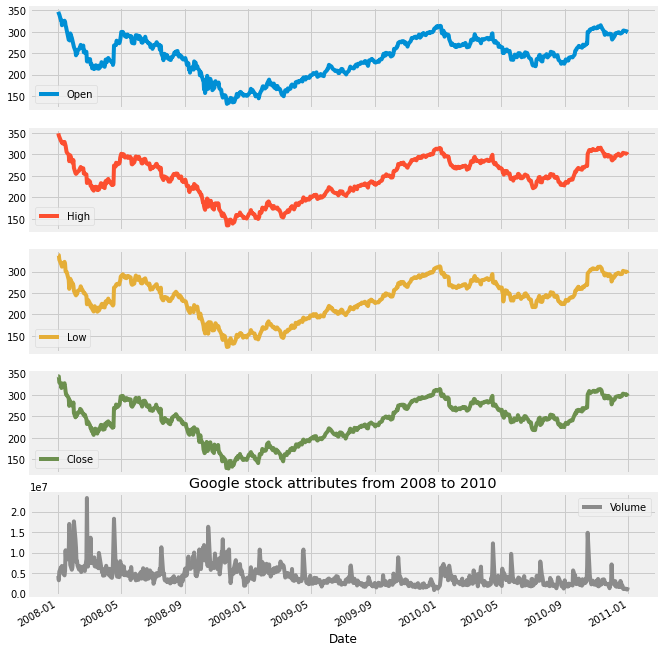

In [7]:
google['2008':'2010'].plot(subplots=True, figsize=(10,12))
plt.title('Google stock attributes from 2008 to 2010')
plt.savefig('stocks.png')
plt.show()

Timestamps and Periods;
Timestamps are used to represent a point in time. 
Periods represent an interval in time. 
Periods can used to check if a specific event in the given period. 
They can also be converted to each other's form.

In [8]:
# Creating a Timestamp
timestamp = pd.Timestamp(2017, 1, 1, 12)
timestamp

Timestamp('2017-01-01 12:00:00')

In [9]:
# Creating a period
period = pd.Period('2017-01-01')
period


Period('2017-01-01', 'D')

In [10]:
# Checking if the given timestamp exists in the given period
period.start_time < timestamp < period.end_time


True

In [11]:
# Converting timestamp to period
new_period = timestamp.to_period(freq='H')
new_period

Period('2017-01-01 12:00', 'H')

In [12]:
# Converting period to timestamp
new_timestamp = period.to_timestamp(freq='H', how='start')
new_timestamp


Timestamp('2017-01-01 00:00:00')

Usage of date_range; date_range is a method that returns a fixed frequency datetimeindex. It is quite useful when creating your own time series attribute for pre-existing data or arranging the whole data around the time series attribute created by you.

In [13]:
# Creating a datetimeindex with daily frequency
dr1 = pd.date_range(start='1/1/18', end='1/9/18')
dr1

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09'],
              dtype='datetime64[ns]', freq='D')

In [14]:
# Creating a datetimeindex with monthly frequency
dr2 = pd.date_range(start='1/1/18', end='1/1/19', freq='M')
dr2


DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='M')

In [15]:
# Creating a datetimeindex without specifying start date and using periods
dr3 = pd.date_range(end='1/4/2014', periods=8)
dr3


DatetimeIndex(['2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04'],
              dtype='datetime64[ns]', freq='D')

In [16]:
# Creating a datetimeindex specifying start date , end date and periods
dr4 = pd.date_range(start='2013-04-24', end='2014-11-27', periods=3)
dr4

DatetimeIndex(['2013-04-24', '2014-02-09', '2014-11-27'], dtype='datetime64[ns]', freq=None)

Usage of to_datetime; pandas.to_datetime() is used for converting arguments to datetime. Here, a DataFrame is converted to a datetime series.

In [17]:
df = pd.DataFrame({'year': [2015, 2016], 'month': [2, 3], 'day': [4, 5]})
df

,year,month,day
0,2015,2,4
1,2016,3,5


In [18]:
df = pd.to_datetime(df)
df

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]

In [19]:
df = pd.to_datetime('01-01-2017')
df

Timestamp('2017-01-01 00:00:00')

Shifting and lags;

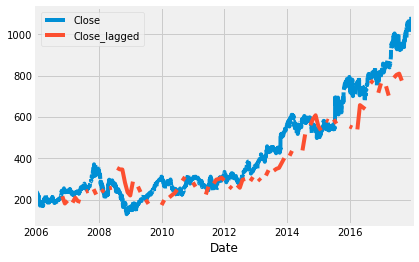

In [20]:
google["Close"].asfreq('D').plot(legend=True)
shifted = google["Close"].asfreq('M').shift(10).plot(legend=True)
shifted.legend(['Close','Close_lagged'])
plt.show()

Resampling;
Upsampling - Time series is resampled from low frequency to high frequency(Monthly to daily frequency). It involves filling or interpolating missing data

Downsampling - Time series is resampled from high frequency to low frequency(Weekly to monthly frequency). It involves aggregation of existing data.

In [21]:
# We downsample from day to 3 day frequency aggregated using mean
df = google.resample('3D').mean()
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,218.953333,222.916667,216.793333,222.173333,1.308182e+07
2006-01-06,228.660000,235.490000,226.850000,233.060000,1.775952e+07
2006-01-09,233.916667,236.696667,232.256667,234.946667,1.030307e+07
2006-01-12,234.745000,235.705000,231.010000,232.705000,8.892716e+06
2006-01-15,231.760000,235.180000,231.500000,233.790000,8.335300e+06


In [22]:
# Shape after resampling(downsampling)
df.shape

(1460, 5)

In [23]:
#we will upsample from 3 day frequency to daily frequency
df = google.resample('D').pad()
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-07,228.66,235.49,226.85,233.06,17759521,GOOGL


In [24]:
# Shape after resampling(upsampling)
df.shape

(4379, 6)

Percent change;

<AxesSubplot:xlabel='Date'>

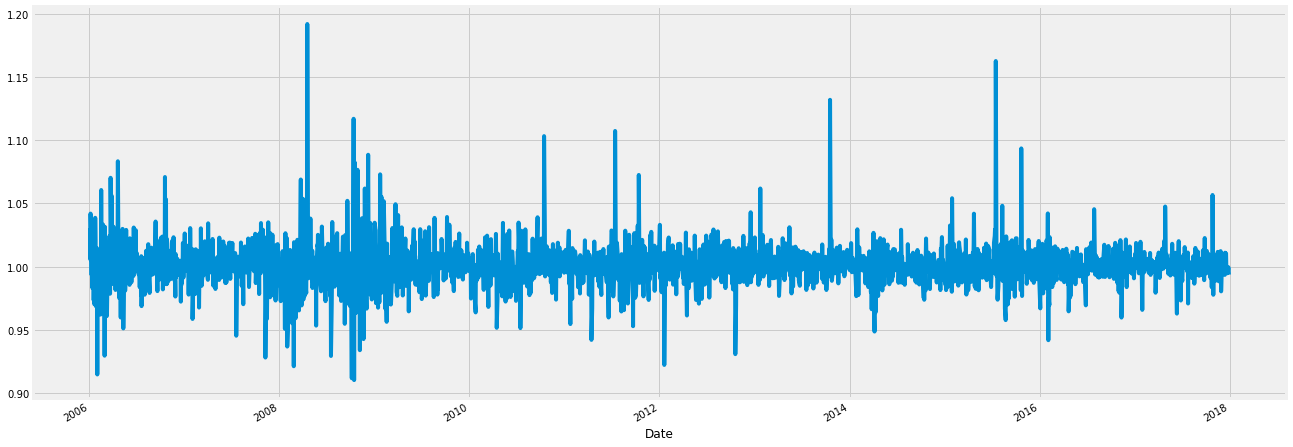

In [25]:
google['Change'] = google.High.div(google.High.shift())
google['Change'].plot(figsize=(20,8))

Stock returns;

<AxesSubplot:xlabel='Date'>

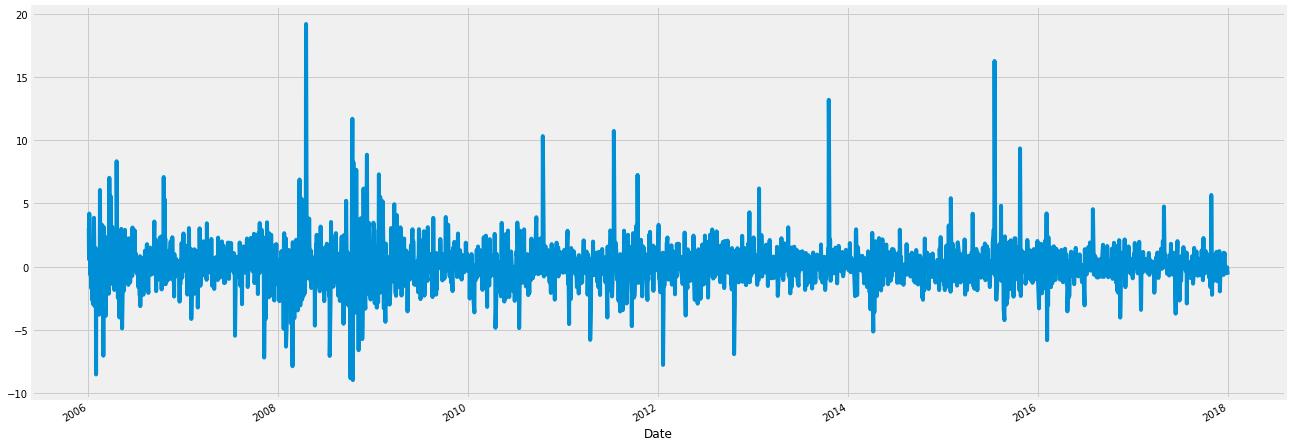

In [26]:
google['Return'] = google.Change.sub(1).mul(100)
google['Return'].plot(figsize=(20,8))

Window functions;
Window functions are used to identify sub periods, calculates sub-metrics of sub-periods.

Rolling - Same size and sliding

Expanding - Contains all prior values

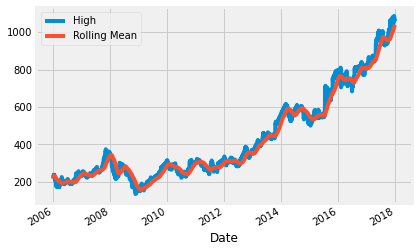

In [27]:
# Rolling window functions
rolling_google = google.High.rolling('90D').mean()
google.High.plot()
rolling_google.plot()
plt.legend(['High','Rolling Mean'])
# Plotting a rolling mean of 90 day window with original High attribute of google stocks
plt.show()
##Now, observe that rolling mean plot is a smoother version of the original plot.

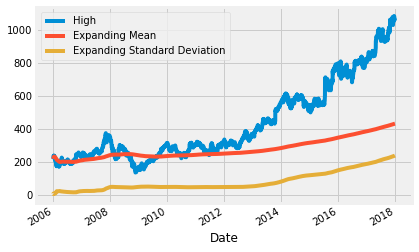

In [28]:
# Expanding window functions
google_mean = google.High.expanding().mean()
google_std = google.High.expanding().std()
google.High.plot()
google_mean.plot()
google_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

Autocorrelation and Partial Autocorrelation;
Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.
Partial Autocorrelation - The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant.

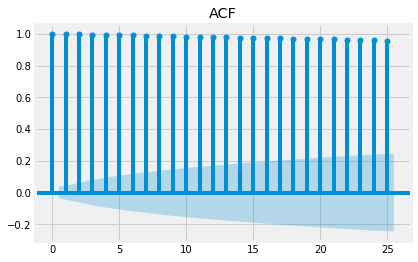

In [29]:
# Autocorrelation of google of Close
plot_acf(google["Close"],lags=25,title="ACF")
plt.show()
#As all lags are either close to 1 or at least greater than the confidence interval, they are statistically significant.

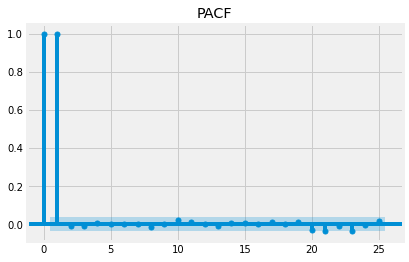

In [30]:
# Partial Autocorrelation of google of Close
plot_pacf(google["Close"],lags=25, title="PACF")
plt.show()
#Here, only 0th, 1st and 20th lag are statistically significant.

<AxesSubplot:xlabel='Date'>

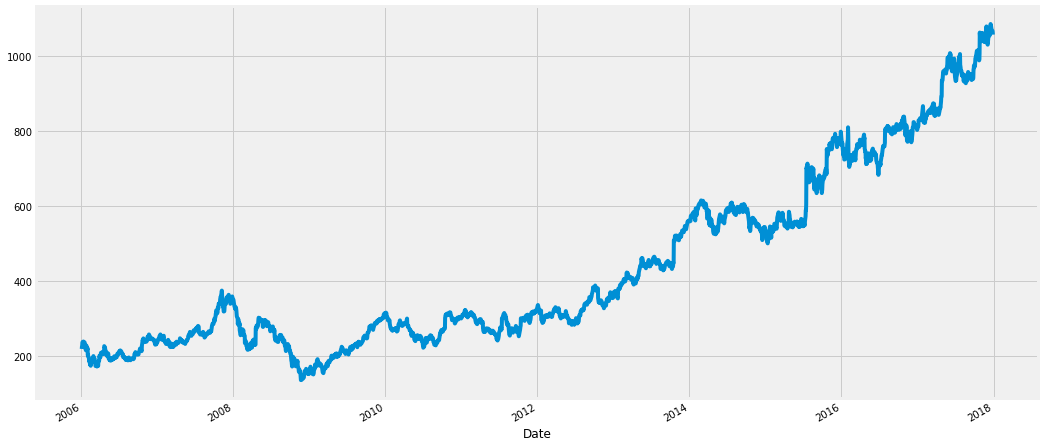

In [31]:
# Let's take Google stocks High for this
google["High"].plot(figsize=(16,8))

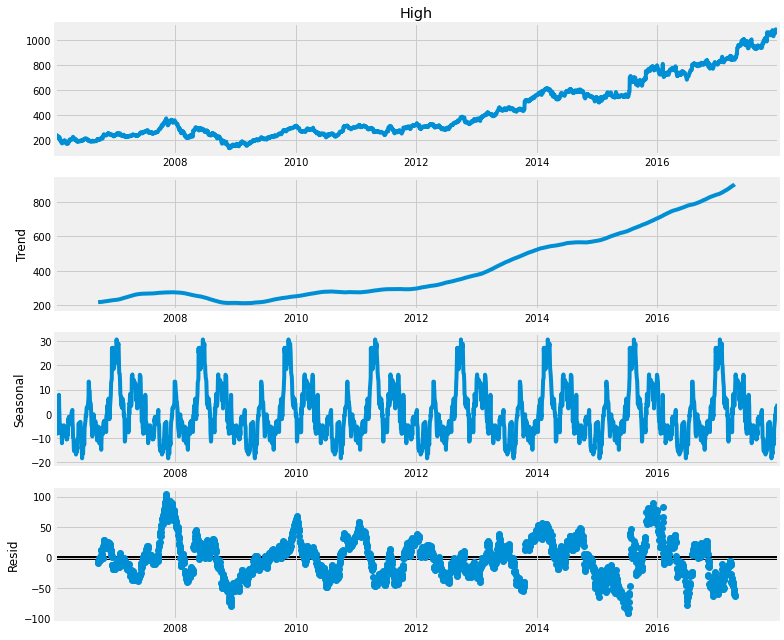

In [32]:
# Now, for decomposition...
rcParams['figure.figsize'] = 11, 9
decomposed_google_volume = sm.tsa.seasonal_decompose(google["High"],freq=360) # The frequncy is annual
figure = decomposed_google_volume.plot()
plt.show()
# There is clearly an upward trend in the above plot.
# You can also see the uniform seasonal change.
# Non-uniform noise that represent outliers and missing values

In [33]:
# Augmented Dickey-Fuller test on volume of google
adf = adfuller(google["Volume"])
print("p-value of google: {}".format(float(adf[1])))
#Now google has p-value 0.0000006510 which is more than 0.05, null hypothesis is rejected and this is not a random walk.

p-value of google: 6.510719605768194e-07


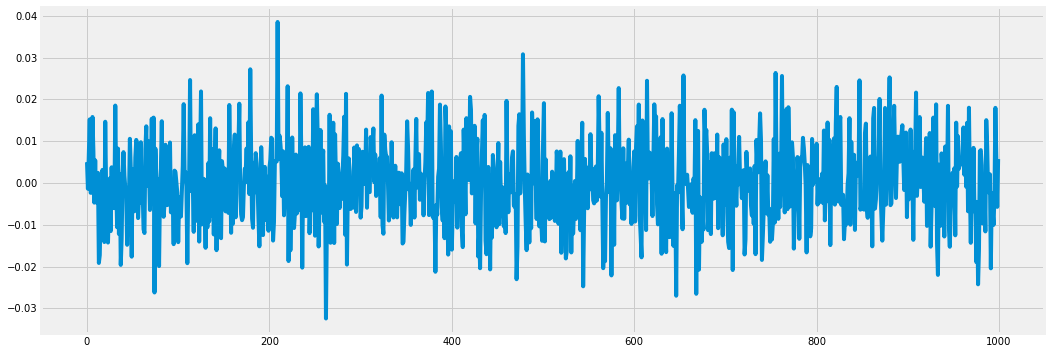

In [34]:
# Generating a random walk
seed(42)
rcParams['figure.figsize'] = 16, 6
random_walk = normal(loc=0, scale=0.01, size=1000)
plt.plot(random_walk)
plt.show()


In [35]:
# fig = ff.create_distplot([random_walk],['Random Walk'],bin_size=0.001)
# iplot(fig, filename='Basic Distplot')

<AxesSubplot:xlabel='Date'>

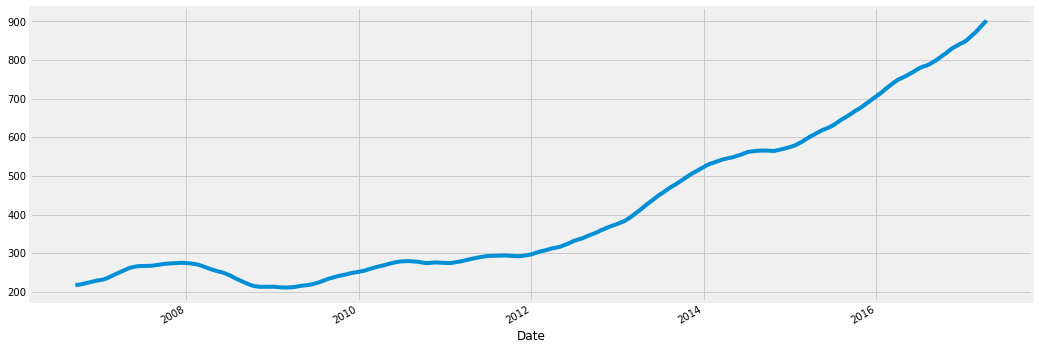

In [36]:
# The original non-stationary plot
decomposed_google_volume.trend.plot()

<AxesSubplot:xlabel='Date'>

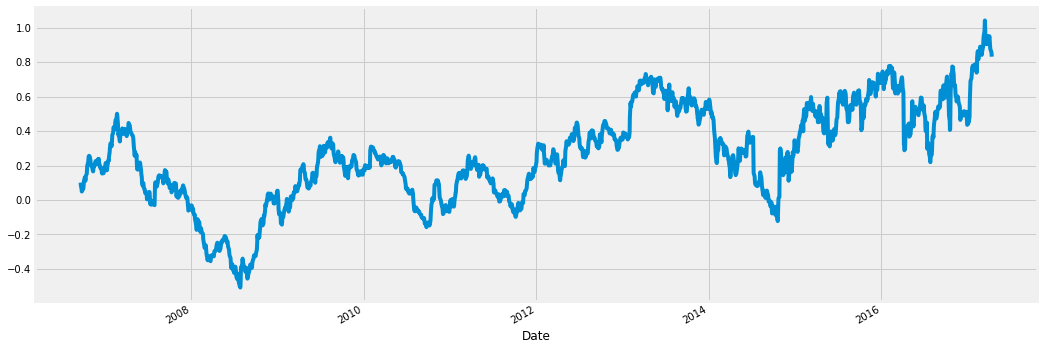

In [37]:
# The new stationary plot
decomposed_google_volume.trend.diff().plot()

# 1. AR (autoregressive) model

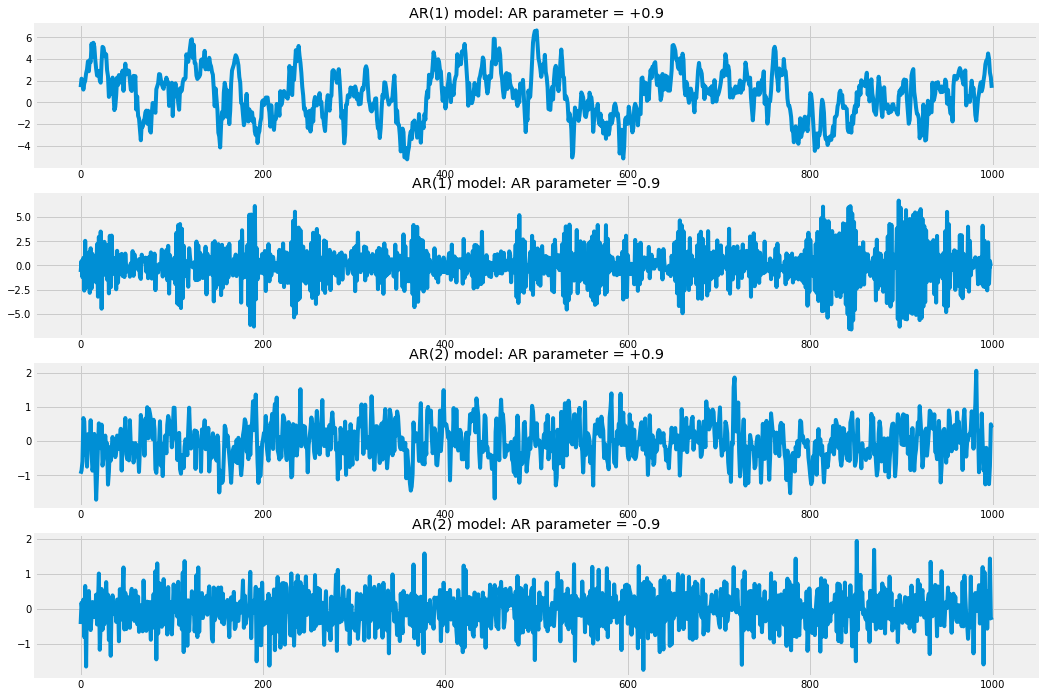

In [38]:
# AR(1) MA(1) model:AR parameter = +0.9
rcParams['figure.figsize'] = 16, 12
plt.subplot(4,1,1)
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)
# We will take care of MA model later
# AR(1) MA(1) AR parameter = -0.9
plt.subplot(4,1,2)
ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim2)
# AR(2) MA(1) AR parameter = 0.9
plt.subplot(4,1,3)
ar3 = np.array([2, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = +0.9')
plt.plot(sim3)
# AR(2) MA(1) AR parameter = -0.9
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = -0.9')
plt.plot(sim4)
plt.show()


Forecasting a simulated model

In [39]:
model = ARMA(sim1, order=(1,0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))
#ϕ is around 0.9 which is what we chose as AR parameter in our first simulated model.

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1415.701
Method:                       css-mle   S.D. of innovations              0.996
Date:                Mon, 07 Dec 2020   AIC                           2837.403
Time:                        19:34:06   BIC                           2852.126
Sample:                             0   HQIC                          2842.998
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7072      0.288      2.454      0.014       0.142       1.272
ar.L1.y        0.8916      0.014     62.742      0.000       0.864       0.919
                                    Roots           

Predicting the models

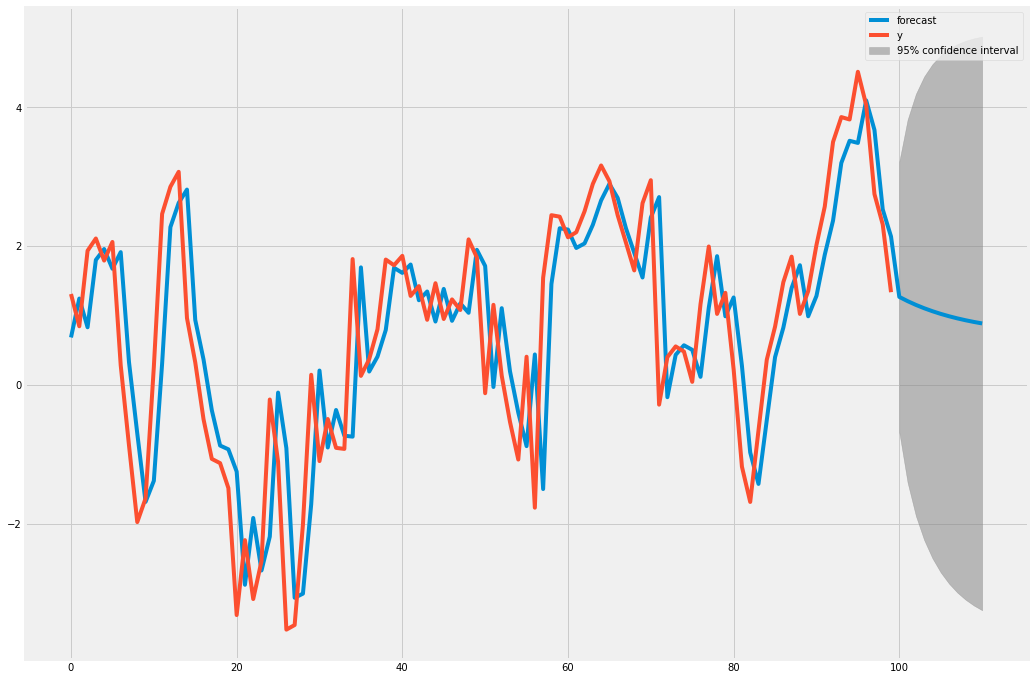

In [40]:
# Predicting simulated AR(1) model 
result.plot_predict(start=900, end=1010)
plt.show()
#y is predicted plot

In [41]:
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.0408054479896363.


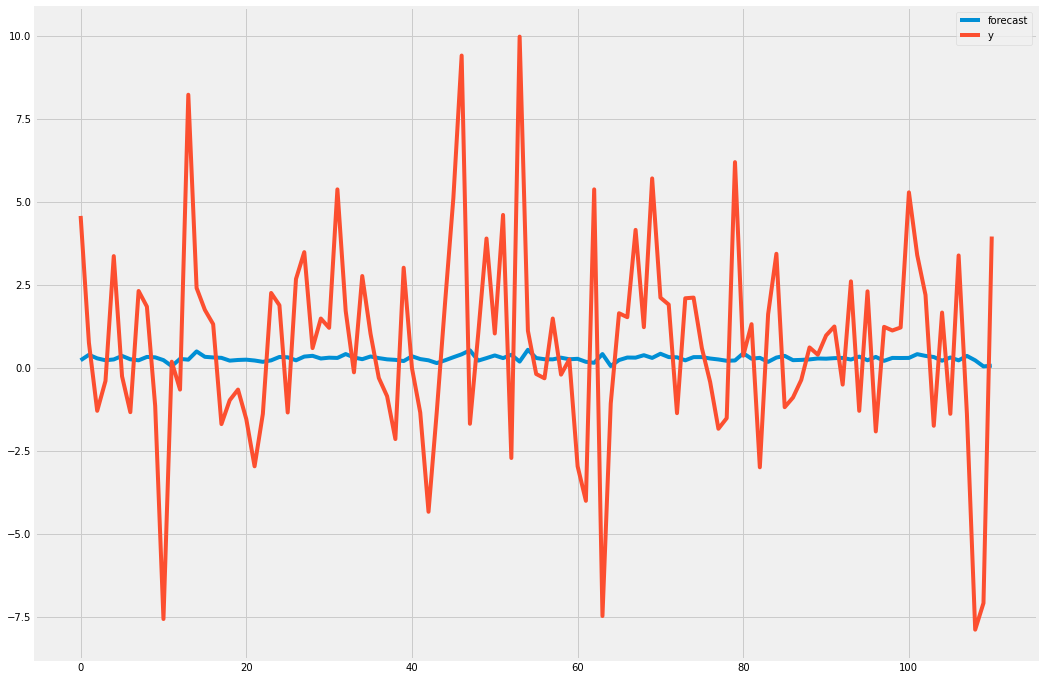

In [42]:
# Predicting closing prices of google
humid = ARMA(google["Close"].diff().iloc[1:].values, order=(1,0))
res = humid.fit()
res.plot_predict(start=900, end=1010)
plt.show()

# 2. MA (moving-average) model

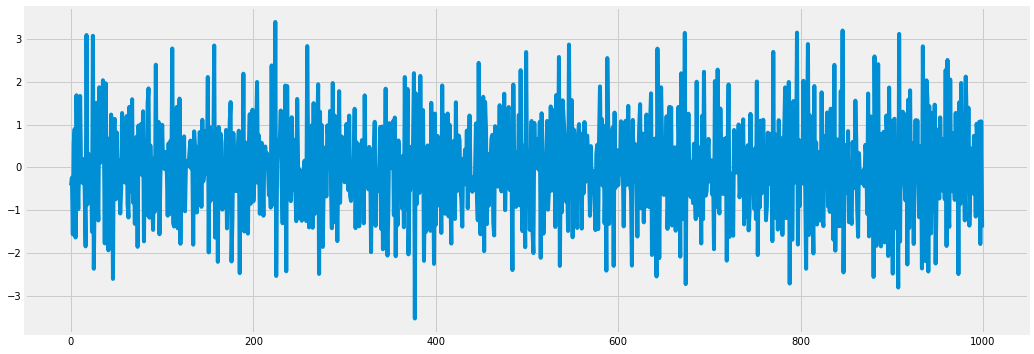

In [43]:
rcParams['figure.figsize'] = 16, 6
ar1 = np.array([1])
ma1 = np.array([1, -0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000)
plt.plot(sim1)

In [44]:
model = ARMA(sim1, order=(0,1))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1423.276
Method:                       css-mle   S.D. of innovations              1.004
Date:                Mon, 07 Dec 2020   AIC                           2852.553
Time:                        19:34:07   BIC                           2867.276
Sample:                             0   HQIC                          2858.148
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0228      0.014     -1.652      0.099      -0.050       0.004
ma.L1.y       -0.5650      0.027    -20.797      0.000      -0.618      -0.512
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(0, 3)   Log Likelihood              -10112.448
Method:                       css-mle   S.D. of innovations              6.902
Date:                Mon, 07 Dec 2020   AIC                          20234.896
Time:                        19:34:07   BIC                          20264.958
Sample:                             0   HQIC                         20245.706
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2769      0.126      2.191      0.028       0.029       0.525
ma.L1.y        0.0268      0.018      1.471      0.141      -0.009       0.063
ma.L2.y        0.0134      0.019      0.724      0.4

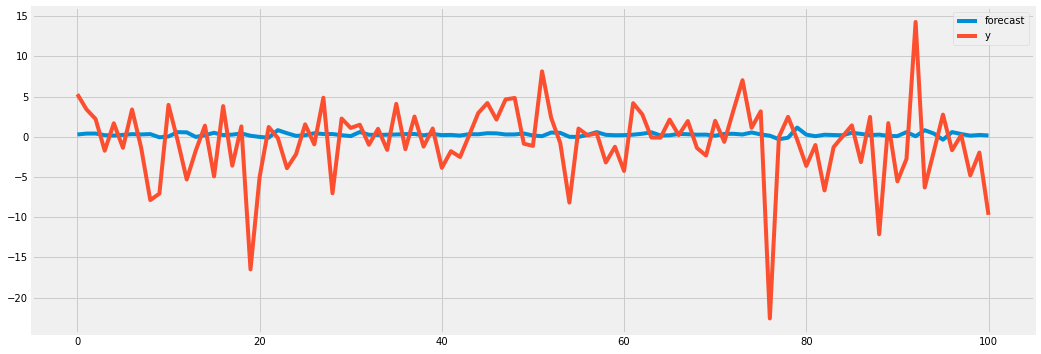

In [45]:
# Forecasting and predicting close google
model = ARMA(google["Close"].diff().iloc[1:].values, order=(0,3))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [46]:
rmse = math.sqrt(mean_squared_error(google["Close"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 4.565698747840615.


# 3. ARMA models
# Prediction using ARMA models


I am not simulating any model because it's quite similar to AR and MA models. Just forecasting and predictions for this one.

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(3, 3)   Log Likelihood              -10110.919
Method:                       css-mle   S.D. of innovations              6.898
Date:                Mon, 07 Dec 2020   AIC                          20237.837
Time:                        19:34:09   BIC                          20285.936
Sample:                             0   HQIC                         20255.133
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2770      0.116      2.386      0.017       0.049       0.505
ar.L1.y        0.6383      0.452      1.411      0.158      -0.248       1.525
ar.L2.y        0.0700      0.528      0.133      0.8

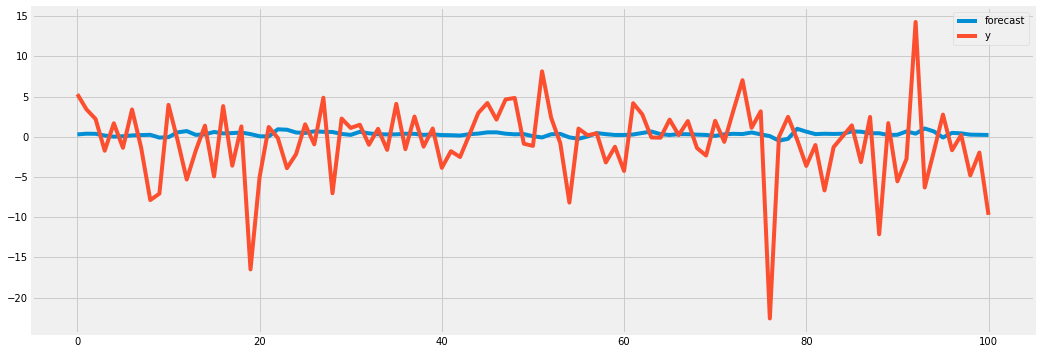

In [48]:
# Forecasting and predicting microsoft stocks volume
model = ARMA(google["Close"].diff().iloc[1:].values, order=(3,3))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [49]:
rmse = math.sqrt(mean_squared_error(google["Close"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 4.5801550237980235.


# 4. ARIMA model

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3017
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -10556.933
Method:                       css-mle   S.D. of innovations              8.006
Date:                Mon, 07 Dec 2020   AIC                          21121.866
Time:                        19:34:10   BIC                          21145.914
Sample:                             1   HQIC                         21130.514
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.075     -0.036      0.971      -0.150       0.145
ar.L1.D.y     -0.6386      0.017    -36.752      0.000      -0.673      -0.605
ar.L2.D.y     -0.2976      0.017    -17.128      0.0

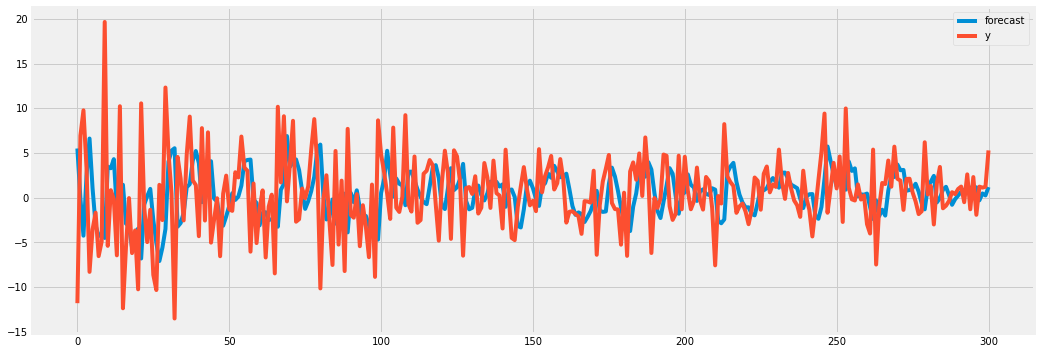

In [50]:
# Predicting the microsoft stocks volume
rcParams['figure.figsize'] = 16, 6
model = ARIMA(google["Close"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
plt.show()

In [51]:
rmse = math.sqrt(mean_squared_error(google["Close"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 7.619287235684237.


# 5. VAR model

In [52]:
# # Predicting closing price of Google
# train_sample = ARIMA(google["Close"].diff().iloc[1:].values
# # = pd.concat([google["Close"].diff().iloc[1:]],axis=1)
# model = sm.tsa.VARMAX(train_sample,order=(2,1),trend='c')
# result = model.fit(maxiter=1000,disp=False)
# print(result.summary())
# predicted_result = result.predict(start=0, end=1000)
# result.plot_diagnostics()
# # calculating error
# rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
# print("The root mean squared error is {}.".format(rmse))

# 6. SARIMA model

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3018
Model:               SARIMAX(4, 0, 4)   Log Likelihood              -10098.380
Date:                Mon, 07 Dec 2020   AIC                          20216.760
Time:                        19:34:23   BIC                          20276.884
Sample:                             0   HQIC                         20238.380
                               - 3018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1107      0.049      2.242      0.025       0.014       0.207
ar.L1          0.2286      0.007     34.786      0.000       0.216       0.241
ar.L2          1.1214      0.005    208.188      0.0

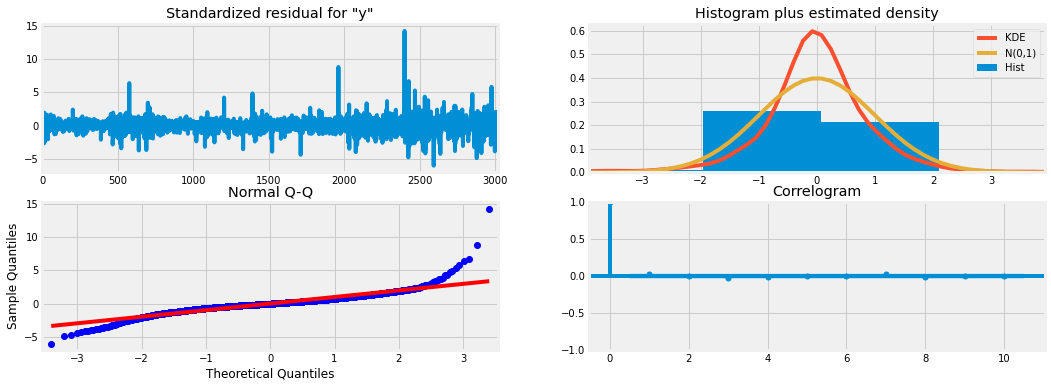

In [53]:
# Predicting closing price of Google'
train_sample = google["Close"].diff().iloc[1:].values
model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

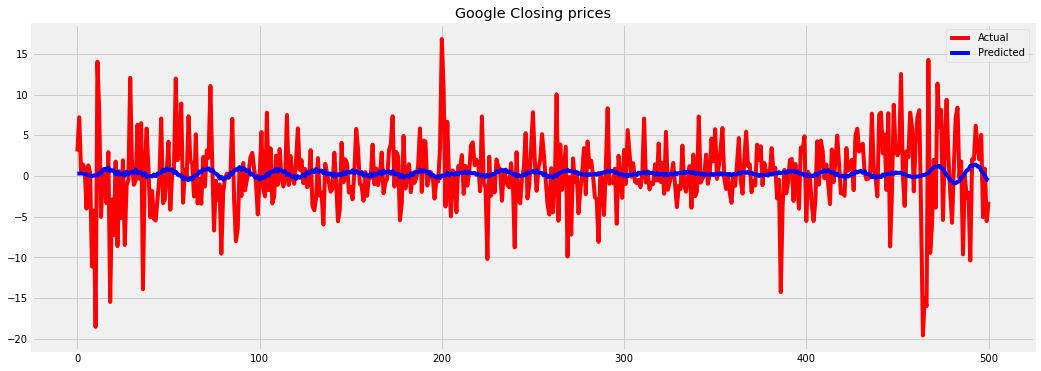

In [54]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Google Closing prices')
plt.show()

# 7. Unobserved components

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                 3018
Model:                    local level   Log Likelihood              -10116.511
Date:                Mon, 07 Dec 2020   AIC                          20237.023
Time:                        19:34:24   BIC                          20249.047
Sample:                             0   HQIC                         20241.346
                               - 3018                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    47.7219      0.384    124.248      0.000      46.969      48.475
sigma2.level      5.033e-05      0.000      0.458      0.647      -0.000       0.000
Ljung-Box (L1) (Q):         

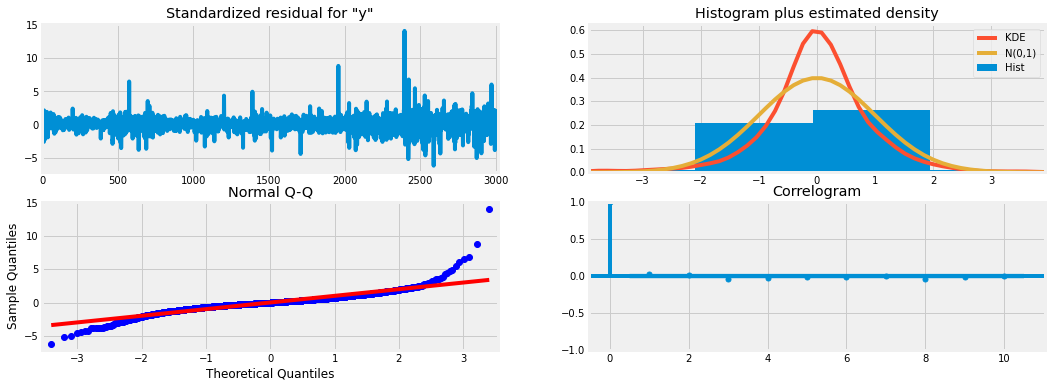

In [55]:
# Predicting closing price of Google'
train_sample = google["Close"].diff().iloc[1:].values
model = sm.tsa.UnobservedComponents(train_sample,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

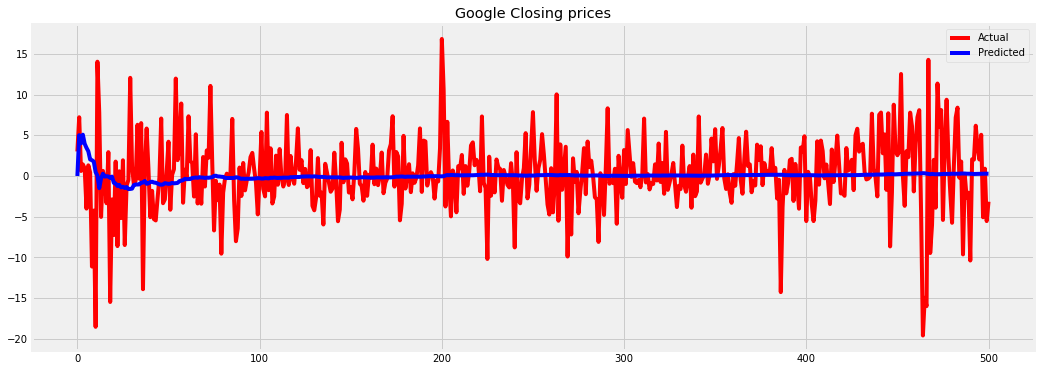

In [56]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Google Closing prices')
plt.show()
